In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyproj import Proj, transform

plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
#기본 정보
coord_std=pd.read_excel('./기본정보_위경도.xlsx')

#숙박 유형
pension=pd.read_excel("./숙박유형_관광펜션업.xlsx")
camping=pd.read_excel("./숙박유형_일반야영장업.xlsx")
hanok=pd.read_excel("./숙박유형_한옥체험업.xlsx")
resort=pd.read_excel("./숙박유형_호텔리조트.xlsx") 

#비대면
alien1=pd.read_csv('./비대면_외지인방문자수_1.csv',encoding='cp949')
alien2=pd.read_csv('./비대면_외지인방문자수_2.csv',encoding='cp949')
resider1=pd.read_csv('./비대면_현지인방문자수_1.csv',encoding='cp949')
resider2=pd.read_csv('./비대면_현지인방문자수_2.csv',encoding='cp949')

#식음및부대시설
meal=pd.read_csv('./부대시설_음식점.csv',encoding='cp949')
cafe=pd.read_csv('./부대시설_휴게음식점.csv',encoding='utf-8')

#콘텐츠
contents1=pd.read_csv('./콘텐츠_관광지_검색순위_상.csv',encoding='cp949')
contents2=pd.read_csv('./콘텐츠_관광지_검색순위_하.csv',encoding='cp949')

숙박유형

In [6]:
def accomm_preprocess(accomm):
    accomm.drop(accomm[(accomm['영업상태구분코드']!=1)].index,inplace=True)
    accomm=accomm[accomm['개방자치단체코드'].between(4799999,5010000)]
    accomm=accomm.loc[:,['개방자치단체코드','좌표정보(X)','좌표정보(Y)']]
    accomm.dropna(axis=0,inplace=True)
    return accomm

ps=accomm_preprocess(pension)
cp=accomm_preprocess(camping)
hk=accomm_preprocess(hanok)
rs=accomm_preprocess(resort)

In [11]:
proj_1 = Proj(init='epsg:2097')
proj_2 = Proj(init='epsg:4326')

def coordinate_transform(accomm):
    convert = transform(proj_1, proj_2, accomm['좌표정보(X)'].values.copy(), accomm['좌표정보(Y)'].values.copy())
    accomm['경도'] = convert[0]
    accomm['위도'] = convert[1]
    return accomm

ps=coordinate_transform(ps)
cp=coordinate_transform(cp)
hk=coordinate_transform(hk)
rs=coordinate_transform(rs)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\user\AppData\Local\Temp\ipykernel_48044\1377615581.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas

In [12]:
accomm_df=pd.concat([ps,cp,hk,rs],ignore_index=True)
accomm_df.drop(['좌표정보(X)','좌표정보(Y)'],axis=1,inplace=True)

In [13]:
acco_n=accomm_df['개방자치단체코드'].value_counts() #지역별 숙소 개수
print(len(acco_n))

22


부대시설

In [14]:
#카페
def cafe_preprocess(cafe):
    cafe.drop(cafe[(cafe['영업상태명']!='영업/정상')].index,inplace=True)
    cafe=cafe.loc[:,['소재지전체주소','좌표정보(X)','좌표정보(Y)']]
    cafe.dropna(axis=0,inplace=True)
    return cafe

cafe_df=cafe_preprocess(cafe)

In [16]:
cafe_address=cafe_df['소재지전체주소']
cafe_address_fr=cafe_address.str.slice(start=4, stop=9, step=1)
cafe_n=cafe_address_fr.value_counts()
print(len(cafe_n))

22


In [17]:
cafe_2=cafe.loc[:,['좌표정보(X)','좌표정보(Y)']]
cafe_coord=coordinate_transform(cafe_2)

C:\Users\user\AppData\Local\Temp\ipykernel_48044\1377615581.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  convert = transform(proj_1, proj_2, accomm['좌표정보(X)'].values.copy(), accomm['좌표정보(Y)'].values.copy())


매력 요소: 비대면 지수, 외부 유입 지수

In [36]:
alien=pd.concat([alien1,alien2],axis=1,ignore_index=True)
alien.drop([2],axis=1,inplace=True) #순위 제거
alien['평균외지인방문자수']=(alien[1]+alien[3])/2

resider=pd.concat([resider1,resider2],axis=1,ignore_index=True)
resider.drop([2],axis=1,inplace=True)
resider['평균현지인방문자수']=(resider[1]+resider[3])/2

regions=alien[0]

calm_score=(alien['평균외지인방문자수']/resider['평균현지인방문자수'])*100 #선행연구 참고
alien_score=alien['평균외지인방문자수']
resider_score=resider['평균현지인방문자수']

attract_df=pd.concat([regions,calm_score,alien_score,resider_score],axis=1)
attract_col=['지역','비대면지수','평균외지인방문자수','평균현지인방문자수']
attract_df.columns=attract_col
attract_df.set_index('지역',inplace=True)

In [37]:
acco_n_fr=list(acco_n)
cafe_n_fr=list(cafe_n)

attract_df['숙소개수']=acco_n_fr
attract_df['카페개수']=cafe_n_fr

attract_corr=attract_df.corr()
print(attract_corr)

              비대면지수  평균외지인방문자수  평균현지인방문자수      숙소개수      카페개수
비대면지수      1.000000  -0.391804  -0.617701 -0.402532 -0.455377
평균외지인방문자수 -0.391804   1.000000   0.937862  0.745483  0.895453
평균현지인방문자수 -0.617701   0.937862   1.000000  0.811491  0.930977
숙소개수      -0.402532   0.745483   0.811491  1.000000  0.901581
카페개수      -0.455377   0.895453   0.930977  0.901581  1.000000


콘텐츠

In [28]:
contents2.drop('광역시/도',axis=1,inplace=True)

In [29]:
count_num=0
sites=[]
rnum=[]

for i in range(len(contents2)): #22'09~23'08
   for j in range(len(contents1)): #21'09~22'08
        if contents2['관광지명'][i]==contents1['관광지명'][j]:
            count_num+=1
            sites.append(contents2['관광지명'][i])
            rnum.append(contents2['검색건수'][i])

print(count_num) #451: 인기 관광지 500곳 중 451곳은 반복해서 수요가 많다.
print(sites) #사람들이 반복해서 찾는 곳

451
['순천만국가정원', '목포역', '순천역', '죽녹원', '오동도', '여수해상케이블카놀아정류장', 'LF스퀘어광양점', '완도항여객선터미널', '향일암', '목포해상케이블카북항승강장', '아쿠아플라넷여수', '여수엑스포역', '목포종합버스터미널', '화엄사', '나주역', '여수예술랜드', '목포연안여객선터미널', '녹동항', '롯데아울렛남악점', '백양사', '여수공항', '메타프로방스', '순천종합버스터미널', '순천만습지', '낙안읍성민속마을', '섬진강기차마을', '유월드루지테마파크', '율포해수욕장', '영광종합버스터미널', '선암사', '아르떼뮤지엄여수', '불갑사', '송광사', '진도항', '녹동신항연안여객선터미널', 'NC백화점순천점', '여수수산시장', '돌산공원', '무안CC', 'CGV순천신대', '장성역', '푸른솔GC', '무안국제공항', '호남해안로드4코스영광백수해안도로', '여수수산물특화시장', '대흥사', '벌교역', '목포항국제여객터미널', '골드레이크CC', '해남종합버스터미널', '담양관방제림', '사성암', '여수종합버스터미널', '여천역', '암태남강선착장', '중마버스터미널', '신지명사십리해수욕장', '무등산CC', '만성리검은모래해변', '메타세쿼이아가로수길', '구례구역', '순천아랫장', '운림산방', '순천오픈세트장', '아크로CC', '여수연안여객선터미널', '정남진장흥토요시장', '강진버스여객터미널', '신기항여객터미널', 'JNJ골프리조트', '소쇄원', '갓바위', '함평엘리체CC', '나로우주센터우주과학관', '천은사', '진남관공사중(2023년12월완공예정)', '땅끝전망대', '골프존카운티순천', '돌머리해변', '무안시외버스터미널', '목포북항', '땅끝선착장', '여수구항방파제등대', '목포근대역사관1관', '청호시장', '다산베아채CC', '파인비치골프링크스', '목포종합수산시장', '화순CC', '웅천친수공원', '광주CC', '메타세콰이어길', '사우스링스영암CC짐앵', '파인힐

Text(0.5, 1.0, '전라남도 관광지 검색량')

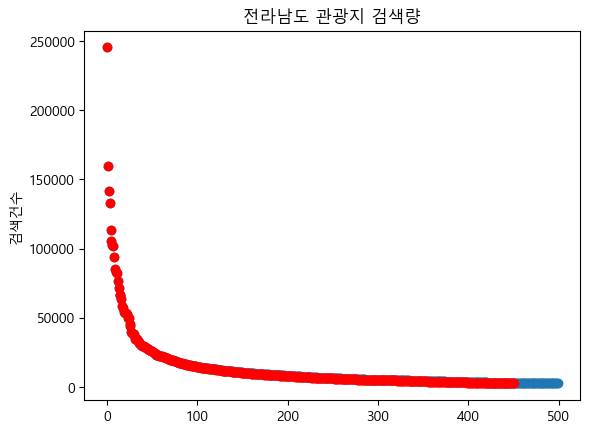

In [38]:
x1=np.arange(len(contents2))
plt.scatter(x1,contents2['검색건수'])
x2=np.arange(len(rnum))
plt.scatter(x2,rnum,c='r')

plt.ylabel('검색건수')
plt.title('전라남도 관광지 검색량') #가는 곳(만) 또 감

In [31]:
ct2=contents2.drop_duplicates(subset=['시/군/구'])
contents_df=ct2.drop(['중분류 카테고리','순위','관광지명','도로명주소'], axis=1).reset_index(drop=True)
print(contents_df)

   시/군/구     소분류 카테고리    검색건수
0    순천시         기타관광  245254
1    목포시         교통시설  159899
2    담양군         자연공원  132973
3    여수시  자연경관(하천/해양)  113284
4    광양시          쇼핑몰  102492
5    완도군         교통시설  101505
6    구례군         종교성지   71502
7    나주시         교통시설   66728
8    고흥군  자연경관(하천/해양)   58260
9    무안군          쇼핑몰   57042
10   장성군         종교성지   54430
11   곡성군         기타관광   45263
12   보성군  자연경관(하천/해양)   39860
13   영광군         교통시설   39224
14   진도군  자연경관(하천/해양)   34692
15   해남군         종교성지   27724
16   신안군         교통시설   23194
17   화순군      육상레저스포츠   22783
18   영암군      육상레저스포츠   21308
19   장흥군           시장   20611
20   강진군         교통시설   20606
21   함평군      육상레저스포츠   19333


데이터 취합

In [43]:
visit=[]

for i in range(len(meal)):
    for j in range(len(contents_df)):
        if meal['항목'][i]==contents_df['시/군/구'][j]:
            visit.append(contents_df['검색건수'][j])

print(visit)

[113284, 245254, 159899, 102492, 66728, 57042, 27724, 21308, 58260, 22783, 101505, 132973, 39224, 39860, 54430, 20611, 20606, 71502, 23194, 34692, 45263, 19333]


In [44]:
meal['검색건수']=visit

meal_columns=['항목','음식점개수','경도','위도','검색건수']
meal.columns=meal_columns

meal.loc[0,'음식점개수']=3875
meal.loc[1,'음식점개수']=3157
meal.loc[2,'음식점개수']=2977
meal.loc[3,'음식점개수']=1974
meal.loc[4,'음식점개수']=1343
meal.loc[5,'음식점개수']=1016

print(meal)

     항목 음식점개수          경도         위도    검색건수
0   여수시  3875  127.662222  34.760374  113284
1   순천시  3157  127.483333  34.950000  245254
2   목포시  2977  126.350000  34.766667  159899
3   광양시  1974  127.695501  34.940548  102492
4   나주시  1343  126.716667  35.033333   66728
5   무안군  1016  126.481686  34.990454   57042
6   해남군   798  126.598927  34.573252   27724
7   영암군   696  126.696792  34.800169   21308
8   고흥군   689  127.284978  34.611222   58260
9   화순군   654  126.986480  35.064503   22783
10  완도군   610  126.755054  34.311060  101505
11  담양군   586  126.988167  35.321139  132973
12  영광군   582  126.511987  35.277172   39224
13  보성군   494  127.079894  34.771456   39860
14  장성군   476  126.784854  35.301833   54430
15  장흥군   444  126.906928  34.681686   20611
16  강진군   434  126.767261  34.642077   20606
17  구례군   419  127.462653  35.202495   71502
18  신안군   385  126.101074  34.827332   23194
19  진도군   376  126.243148  34.460868   34692
20  곡성군   314  127.291918  35.281955   45263
21  함평군   

In [45]:
sites_num=pd.DataFrame([76,41,40,26,25,19,25,12,16,23,18,
                        23,21,16,18,13,17,18,14,16,11,12])
tour_df=pd.concat([meal,sites_num],axis=1,ignore_index=True)
tour_col=['지역','음식점개수','경도','위도','검색건수','관광지개수']
tour_df.columns=tour_col
tour_df.set_index('지역',inplace=True)
tour_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 여수시 to 함평군
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   음식점개수   22 non-null     object 
 1   경도      22 non-null     float64
 2   위도      22 non-null     float64
 3   검색건수    22 non-null     int64  
 4   관광지개수   22 non-null     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 1.0+ KB


In [46]:
a_index=attract_df.index
t_index=tour_df.index

calmness=[]
accommodation=[]
cafeteria=[]
entranger=[]
aborigene=[]

for i in range(len(tour_df)):
    for j in range(len(attract_df)):
        if t_index[i]==a_index[j]:
            calmness.append(attract_df['비대면지수'][j])
            accommodation.append(attract_df['숙소개수'][j])
            cafeteria.append(attract_df['카페개수'][j])
            aborigene.append(attract_df['평균현지인방문자수'][j])
            entranger.append(attract_df['평균외지인방문자수'][j])
        else:
            continue


tour_df['비대면지수']=calmness
tour_df['숙소개수']=accommodation
tour_df['카페개수']=cafeteria
tour_df['평균외지인방문자수']=entranger
tour_df['평균현지인방문자수']=aborigene

print(tour_df) #최종 데이터프레임

    음식점개수          경도         위도    검색건수  관광지개수       비대면지수  숙소개수  카페개수  \
지역                                                                        
여수시  3875  127.662222  34.760374  113284     76   49.405687   143  1179   
순천시  3157  127.483333  34.950000  245254     41   43.061186    70   860   
목포시  2977  126.350000  34.766667  159899     40   41.232053   268  1226   
광양시  1974  127.695501  34.940548  102492     26   49.087961    44   416   
나주시  1343  126.716667  35.033333   66728     25   62.008706    52   563   
무안군  1016  126.481686  34.990454   57042     19   79.961388    17   121   
해남군   798  126.598927  34.573252   27724     25   73.605863    25   139   
영암군   696  126.696792  34.800169   21308     12   80.345210    20   136   
고흥군   689  127.284978  34.611222   58260     16   69.595750    28   260   
화순군   654  126.986480  35.064503   22783     23   84.238047    27   167   
완도군   610  126.755054  34.311060  101505     18   52.339439    11    85   
담양군   586  126.988167  35

In [59]:
tour_df.corr() 
#외지인방문자: 현지인>음식점>카페>관광지>검색건수>숙소개수
#현지인방문자: 음식점>외지>카페>관광지>숙소>검색건수

,음식점개수,경도,위도,검색건수,관광지개수,비대면지수,숙소개수,카페개수,평균외지인방문자수,평균현지인방문자수
음식점개수,1.000000,0.397433,-0.090093,0.752511,0.914170,-0.594512,0.764677,0.930127,0.924054,0.972125
경도,0.397433,1.000000,0.194568,0.406329,0.399860,-0.177396,0.100846,0.361621,0.280915,0.283066
위도,-0.090093,0.194568,1.000000,0.068769,-0.066521,0.515137,-0.048719,0.005472,0.120852,-0.071466
검색건수,0.752511,0.406329,0.068769,1.000000,0.599145,-0.314661,0.572655,0.743414,0.774775,0.792414
관광지개수,0.914170,0.399860,-0.066521,0.599145,1.000000,-0.452021,0.677216,0.857354,0.845099,0.835461
비대면지수,-0.594512,-0.177396,0.515137,-0.314661,-0.452021,1.000000,-0.402532,-0.455377,-0.391804,-0.617701
숙소개수,0.764677,0.100846,-0.048719,0.572655,0.677216,-0.402532,1.000000,0.901581,0.745483,0.811491
카페개수,0.930127,0.361621,0.005472,0.743414,0.857354,-0.455377,0.901581,1.000000,0.895453,0.930977
평균외지인방문자수,0.924054,0.280915,0.120852,0.774775,0.845099,-0.391804,0.745483,0.895453,1.000000,0.937862
평균현지인방문자수,0.972125,0.283066,-0.071466,0.792414,0.835461,-0.617701,0.811491,0.930977,0.937862,1.000000


시각화

In [51]:
xmin=min(coord_std['경도'])
xmax=max(coord_std['경도'])
ymin=min(coord_std['위도'])
ymax=max(coord_std['위도'])

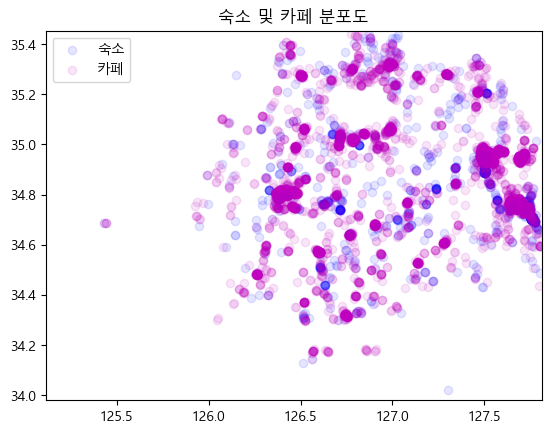

In [52]:
#숙소유형
plt.scatter(x=accomm_df['경도'],y=accomm_df['위도'],alpha=0.1,c='b',label='숙소')

plt.scatter(x=cafe_coord['경도'],y=cafe_coord['위도'],alpha=0.1,c='m',label='카페')

plt.title('숙소 및 카페 분포도')

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.legend()

plt.show()

array([[<Axes: title={'center': '경도'}>, <Axes: title={'center': '위도'}>,
        <Axes: title={'center': '검색건수'}>],
       [<Axes: title={'center': '관광지개수'}>,
        <Axes: title={'center': '비대면지수'}>,
        <Axes: title={'center': '숙소개수'}>],
       [<Axes: title={'center': '카페개수'}>,
        <Axes: title={'center': '평균외지인방문자수'}>,
        <Axes: title={'center': '평균현지인방문자수'}>]], dtype=object)

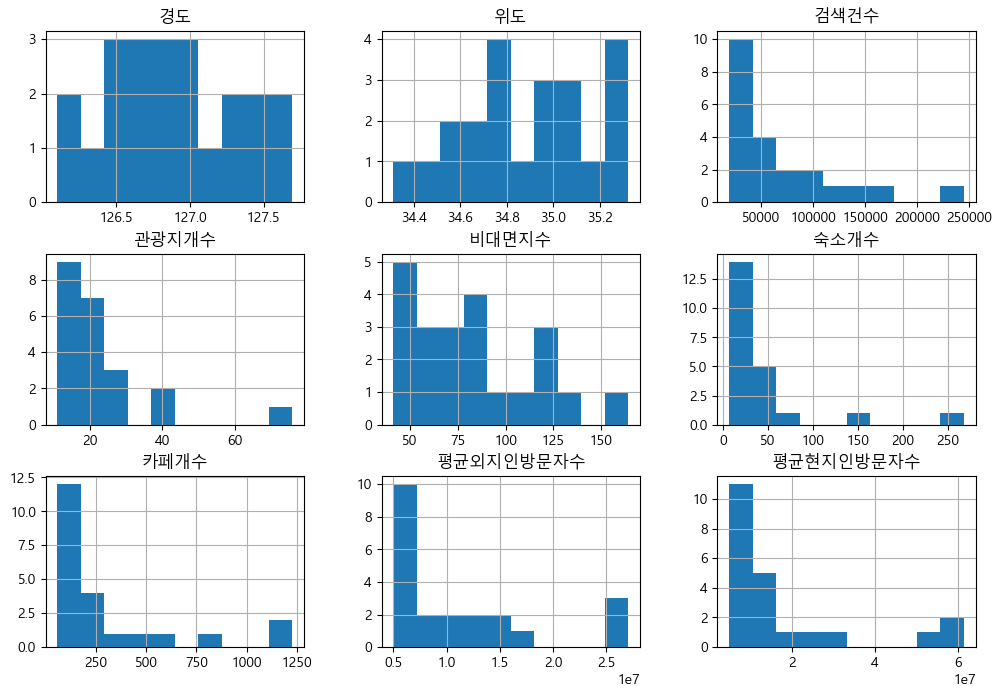

In [57]:
tour_df.hist(figsize=(12,8))